# Deep Learning based on CNNs: Facial Emotion Recognition 

Github user: F-Riv

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
import numpy as np
import seaborn as sns
import Plots
import Create_models
import numpy as np
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.utils import class_weight
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd 


sns.set_theme(style="darkgrid")

In [2]:
# List available physical devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check if TensorFlow can access the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  1
GPU is available


# Load datasets from folders

Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.


2024-05-29 15:59:20.784328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


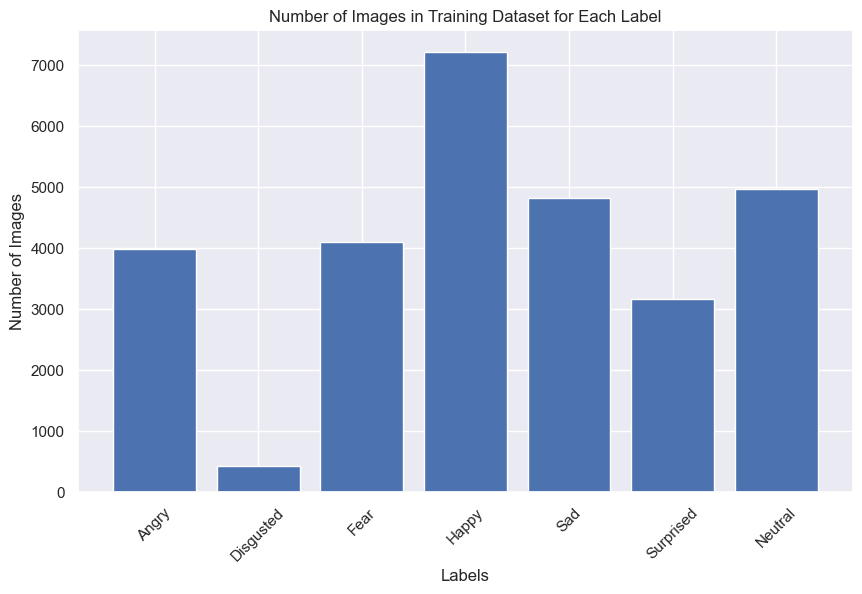

Class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8491274770777877, 5: 1.293372978330405, 6: 0.8260394187886635}


In [ ]:
# Define image size and batch size (for my custom models I use the original size of images in the dataset)
IMG_SIZE = (48, 48)
BATCH_SIZE = 128

# Load the training dataset
train_dataset = image_dataset_from_directory(
    'data/train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale'
)

# Load the validation dataset
val_dataset = image_dataset_from_directory(
    'data/val',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale'
)
 

labels = ['Angry', 'Disgusted', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

all_labels = np.concatenate([y for x, y in train_dataset], axis=0)


Plots.plot_instances_per_class(labels, all_labels)

# Compute class weights (not used as it decrease validation accuracy)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(all_labels),
                                                  y=all_labels)
class_weights_dict = dict(zip(np.unique(all_labels), class_weights))

print("Class weights:", class_weights_dict)



Print Some example images

(128, 48, 48, 1)
(128, 48, 48, 1)
(128, 48, 48, 1)
(128, 48, 48, 1)
(128, 48, 48, 1)
(128, 48, 48, 1)
(128, 48, 48, 1)
(128, 48, 48, 1)
(128, 48, 48, 1)


2024-05-28 12:02:44.267575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


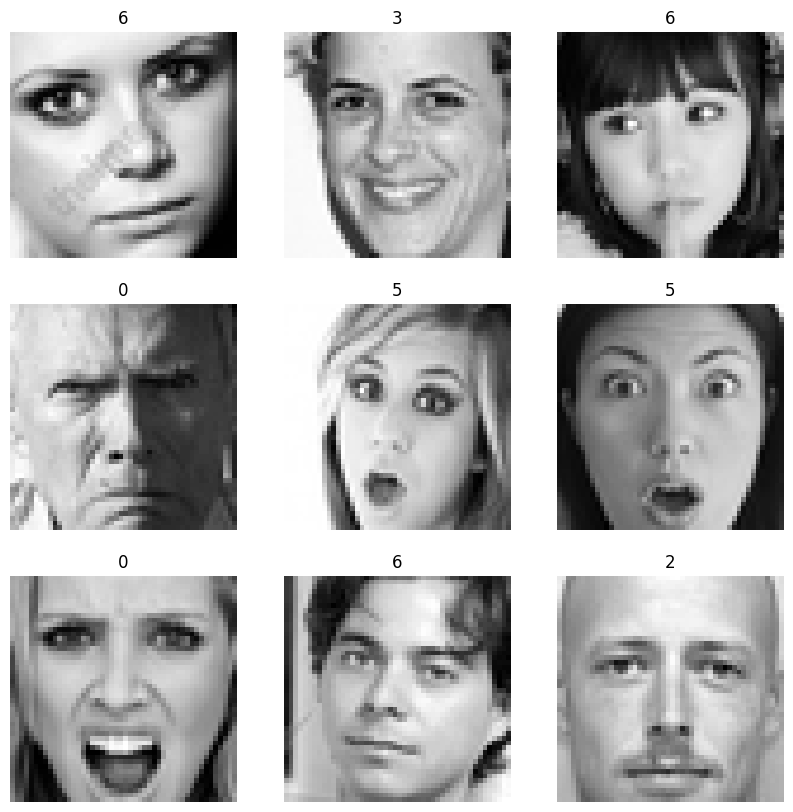

In [21]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        print(images.shape)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")


# Model experiments

## First model 

### Create function

In [3]:
def create_model(num_classes):
    model = tf.keras.Sequential([
        
    layers.Input(shape=(48, 48, 1)),


    # First block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Second block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    

    # Forth block
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])
           
    model.summary()
    return model





### Compile the model

In [ ]:
# Learning rate decay every 1000 steps 
model = create_model(num_classes=7)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)




# Save the weights when validation accuracy is higher 
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights/1.weights.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)




# Optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
   
)
epochs = 50


# Class weights are not used as they decrease the performance of the model 
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint]

)



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,469,031 (5.60 MB)

 Trainable params: 1,468,583 (5.60 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2188 - loss: 2.3393
Epoch 1: val_accuracy improved from -inf to 0.29117, saving model to weights/1.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - accuracy: 0.2188 - loss: 2.3375 - val_accuracy: 0.2912 - val_loss: 1.7537
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2700 - loss: 1.7718
Epoch 2: val_accuracy did not improve from 0.29117
225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - accuracy: 0.2700 - loss: 1.7717 - val_accuracy: 0.2864 - val_loss: 1.6988
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2932 - loss: 1.6921
Epoch 3: val_accuracy improved from 0.29117 to 0.39092, saving model to weights/1.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - accuracy: 0.2932 - loss: 1.6920 - val_accuracy: 0.3909 - val_loss: 1.5308
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3280 - loss: 1.6268
Epoch 4: val_accuracy improved from 0.39092 to 0.41376

### Plot training/validation accuracy and loss

In [60]:

# Save history to txt file (to avoid training again for plots)
with open('Histories/training_history_1.txt', 'w') as f:
    for key in history.history.keys():
        f.write(f'{key}: {history.history[key]}\n')



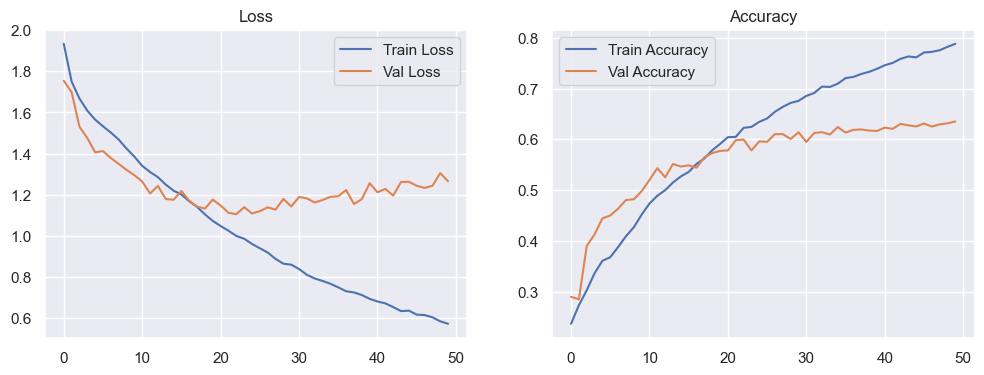

In [20]:
# List of all the histories (used for a comparative plot later)
histories = []
# Current history (to read from .txt file)
history = {}

# Open the txt file and read the saved history
with open('Histories/training_history_1.txt', 'r') as f:

    for line in f:
        key, value_str = line.strip().split(': ')
        value_list = [float(val) for val in value_str[1:-1].split(',')]
        history[key] = value_list

# Save the history in a list for the comparative plot
histories.append(history)

# One-history plot
Plots.plot_history_from_file(history)

## Second model: maxpooling vs. averagepooling
In the second and in the third block maxpooling is changed with averagepooling. Average pooling provides a more smoother representation of features and it is less sensitive to outliers. This should help the model to catch more prominent local features first by maxpooling and to capture more global patterns after by averagepooling. 

In [ ]:
def create_model_2(num_classes):
    model = tf.keras.Sequential([
    layers.Input(shape=(48, 48, 1)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # Averagepooling instead of maxpooling 
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # Averagepooling instead of maxpooling 
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
           
    model.summary()
    return model

model_2 = create_model_2(num_classes=7)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)


checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights/2.weights.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_2.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
   
)


epochs = 50
history_2 = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint]

)




Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 12, 12, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 6, 6, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,469,031 (5.60 MB)

 Trainable params: 1,468,583 (5.60 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2441 - loss: 1.9042
Epoch 1: val_accuracy improved from -inf to 0.31039, saving model to 2.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.2443 - loss: 1.9036 - val_accuracy: 0.3104 - val_loss: 1.7162
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3564 - loss: 1.5979
Epoch 2: val_accuracy improved from 0.31039 to 0.41878, saving model to 2.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - accuracy: 0.3565 - loss: 1.5977 - val_accuracy: 0.4188 - val_loss: 1.5104
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4237 - loss: 1.4684
Epoch 3: val_accuracy improved from 0.41878 to 0.47562, saving model to 2.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.4237 - loss: 1.4682 - val_accuracy: 0.4756 - val_loss: 1.3418
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4696 - loss: 1.3728
Epoch 4: val_accuracy improved from 

In [ ]:
with open('Histories/training_history_2.txt', 'w') as f:
    for key in history_2.history.keys():
        f.write(f'{key}: {history_2.history[key]}\n')

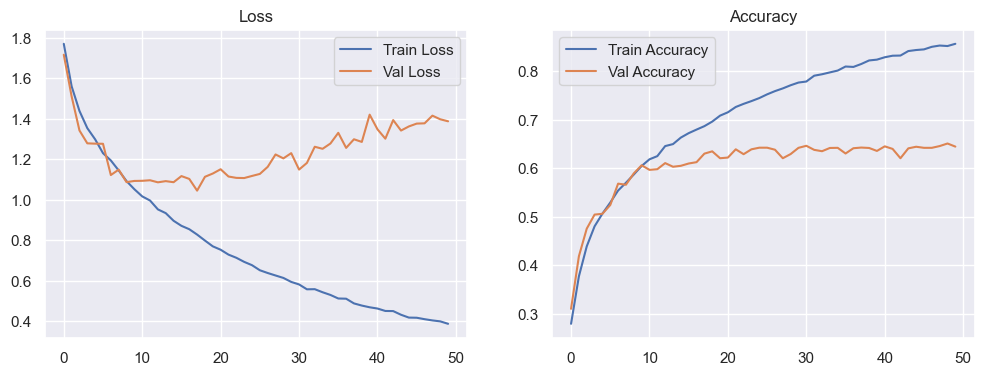

In [21]:
history_2 = {}


# Open the txt file and read the saved history
with open('Histories/training_history_2.txt', 'r') as f:
   
    for line in f:
        key, value_str = line.strip().split(': ')
        value_list = [float(val) for val in value_str[1:-1].split(',')]
        history_2[key] = value_list


histories.append(history_2)
Plots.plot_history_from_file(history_2)



Final validation accuracy improves with using averagepooing in the second block so for the next experiments I will keep this variation. 

## Third model: more filters

Increasing the number of filters allows the model to catch more features from the input.
In this way there will be more parameters to be considered before the flatten layer.

In [ ]:
def create_model_3(num_classes):
    model = tf.keras.Sequential([
    layers.Input(shape=(48, 48, 1)),
    
   # Number of filters is doubled in each block 
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),

    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
           
    model.summary()
    return model


model_3 = create_model_3(num_classes=7)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)


checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights/3.weights.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_3.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
   
)

epochs = 50
history_3 = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint]

)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,868,743 (22.39 MB)

 Trainable params: 5,867,847 (22.38 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.2093 - loss: 2.5406
Epoch 1: val_accuracy improved from -inf to 0.28392, saving model to weights/3.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 97s 403ms/step - accuracy: 0.2094 - loss: 2.5381 - val_accuracy: 0.2839 - val_loss: 1.7727
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.3031 - loss: 1.7079
Epoch 2: val_accuracy improved from 0.28392 to 0.36138, saving model to weights/3.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 87s 387ms/step - accuracy: 0.3033 - loss: 1.7076 - val_accuracy: 0.3614 - val_loss: 1.6254
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.4033 - loss: 1.5109
Epoch 3: val_accuracy improved from 0.36138 to 0.46643, saving model to weights/3.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 88s 392ms/step - accuracy: 0.4034 - loss: 1.5107 - val_accuracy: 0.4664 - val_loss: 1.3638
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4508 - loss: 1.3944
Epoch 4: val

In [41]:

with open('Histories/training_history_3.txt', 'w') as f:
    for key in history_3.history.keys():
        f.write(f'{key}: {history_3.history[key]}\n')

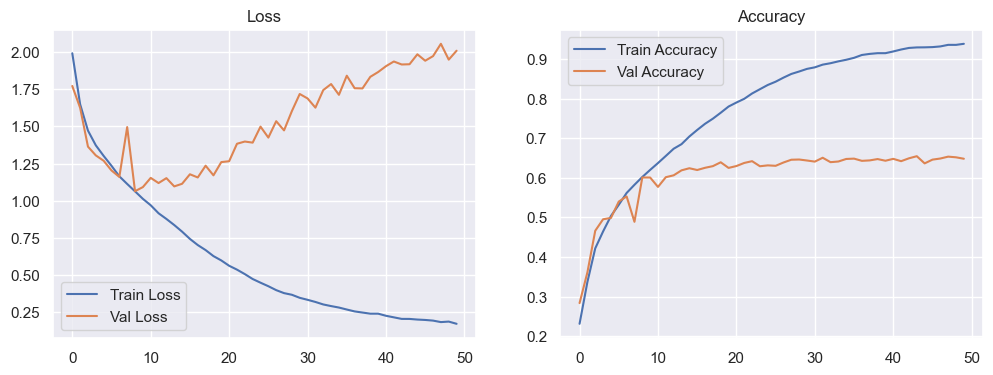

In [22]:
history_3 = {}


# Open the txt file and read the saved history
with open('Histories/training_history_3.txt', 'r') as f:
   
    for line in f:
        key, value_str = line.strip().split(': ')
        value_list = [float(val) for val in value_str[1:-1].split(',')]
        history_3[key] = value_list


histories.append(history_3)
Plots.plot_history_from_file(history_3)

## Forth model: increase kernel size

Kernel size is increased from (3,3) to (5,5)

In [43]:
def create_model_4(num_classes):
    model = tf.keras.Sequential([
    layers.Input(shape=(48, 48, 1)),
     
    layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
           
    model.summary()
    return model


model_4 = create_model_4(num_classes=7)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)


checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights/4.weights.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_4.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
   
)

epochs = 50
history_4 = model_4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint]

)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 48, 48, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 48, 48, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 24, 24, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 12, 12, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 12, 12, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 6, 6, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,977,447 (7.54 MB)

 Trainable params: 1,976,999 (7.54 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2383 - loss: 1.9937
Epoch 1: val_accuracy improved from -inf to 0.38590, saving model to weights/4.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 248ms/step - accuracy: 0.2386 - loss: 1.9928 - val_accuracy: 0.3859 - val_loss: 1.6435
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3859 - loss: 1.5532
Epoch 2: val_accuracy did not improve from 0.38590
225/225 ━━━━━━━━━━━━━━━━━━━━ 51s 228ms/step - accuracy: 0.3860 - loss: 1.5530 - val_accuracy: 0.3644 - val_loss: 1.6563
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4518 - loss: 1.4077
Epoch 3: val_accuracy improved from 0.38590 to 0.41962, saving model to weights/4.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 51s 226ms/step - accuracy: 0.4519 - loss: 1.4076 - val_accuracy: 0.4196 - val_loss: 1.5616
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4996 - loss: 1.3133
Epoch 4: val_accuracy improved from 0.41962 to 0.48203

In [44]:
with open('Histories/training_history_4.txt', 'w') as f:
    for key in history_4.history.keys():
        f.write(f'{key}: {history_4.history[key]}\n')

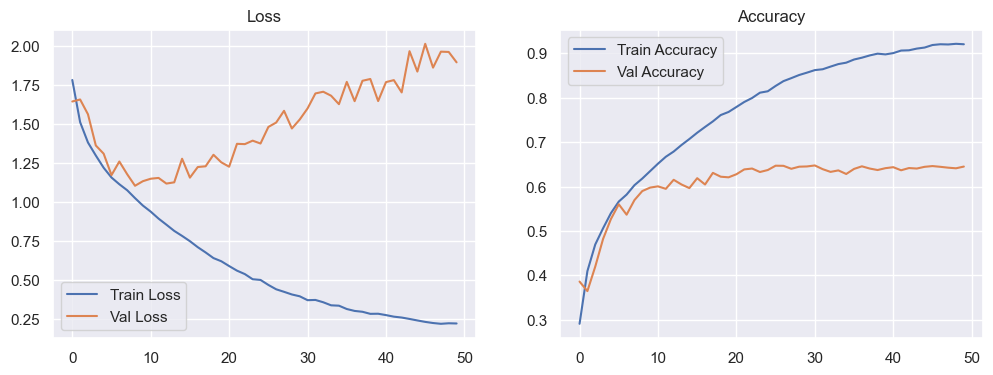

In [23]:
history_4 = {}


# Open the txt file and read the saved history
with open('Histories/training_history_4.txt', 'r') as f:
  
    for line in f:
        key, value_str = line.strip().split(': ')
        value_list = [float(val) for val in value_str[1:-1].split(',')]
        history_4[key] = value_list


histories.append(history_4)
Plots.plot_history_from_file(history_4)

Increasing the kernel size did not help the validation accuracy to increase.

## Fifth model: one more block of layers
More layers allow the model to detect more complex patterns between features

In [46]:
def create_model_5(num_classes):
    model = tf.keras.Sequential([
    layers.Input(shape=(48, 48, 1)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),

    # Extra block     
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
   
   
   
   
])
           
    model.summary()
    return model

model_5 = create_model_5(num_classes=7)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)


checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights/5.weights.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_5.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
   
)


epochs = 50
history_5 = model_5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint]

)




Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 6, 6, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 3, 3, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     1,180,16

 Total params: 2,357,351 (8.99 MB)

 Trainable params: 2,356,391 (8.99 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2453 - loss: 1.9499
Epoch 1: val_accuracy improved from -inf to 0.39677, saving model to weights/5.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 100s 397ms/step - accuracy: 0.2455 - loss: 1.9490 - val_accuracy: 0.3968 - val_loss: 1.4991
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.4140 - loss: 1.4972
Epoch 2: val_accuracy improved from 0.39677 to 0.45528, saving model to weights/5.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 71s 317ms/step - accuracy: 0.4141 - loss: 1.4970 - val_accuracy: 0.4553 - val_loss: 1.3812
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.4888 - loss: 1.3405
Epoch 3: val_accuracy improved from 0.45528 to 0.49512, saving model to weights/5.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 364ms/step - accuracy: 0.4889 - loss: 1.3403 - val_accuracy: 0.4951 - val_loss: 1.3645
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5233 - loss: 1.2565
Epoch 4: va

In [47]:
with open('Histories/training_history_5.txt', 'w') as f:
    for key in history_5.history.keys():
        f.write(f'{key}: {history_5.history[key]}\n')

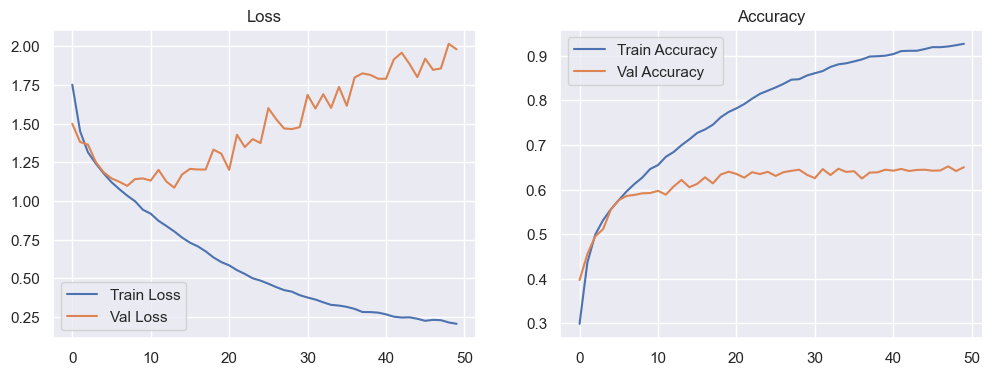

In [24]:
history_5 = {}


# Open the txt file and read the saved history
with open('Histories/training_history_5.txt', 'r') as f:
    
    for line in f:
        key, value_str = line.strip().split(': ')
        value_list = [float(val) for val in value_str[1:-1].split(',')]
        history_5[key] = value_list


histories.append(history_5)
Plots.plot_history_from_file(history_5)

## Sixth model: same padding vs. valid padding

In [49]:
def create_model_6(num_classes):
    model = tf.keras.Sequential([

    layers.Input(shape=(48, 48, 1)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    # In the second convolutional layer for each block padding is changed to valid 
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='valid'),
    layers.AveragePooling2D((2, 2)),
    layers.Dropout(0.25),

    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
           
    model.summary()
    return model


model_6 = create_model_6(num_classes=7)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)


checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights/6.weights.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                verbose=1)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_6.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
   
)

epochs = 50
history_6 = model_6.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint]

)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 10, 10, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 4, 4, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,671 (3.10 MB)

 Trainable params: 813,223 (3.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2674 - loss: 1.8409
Epoch 1: val_accuracy improved from -inf to 0.41739, saving model to weights/6.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step - accuracy: 0.2677 - loss: 1.8403 - val_accuracy: 0.4174 - val_loss: 1.5301
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4256 - loss: 1.4808
Epoch 2: val_accuracy improved from 0.41739 to 0.44804, saving model to weights/6.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.4257 - loss: 1.4807 - val_accuracy: 0.4480 - val_loss: 1.4212
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4891 - loss: 1.3422
Epoch 3: val_accuracy improved from 0.44804 to 0.52661, saving model to weights/6.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.4892 - loss: 1.3421 - val_accuracy: 0.5266 - val_loss: 1.2164
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5094 - loss: 1.2779
Epoch 4: val

In [50]:
with open('Histories/training_history_6.txt', 'w') as f:
    for key in history_6.history.keys():
        f.write(f'{key}: {history_6.history[key]}\n')

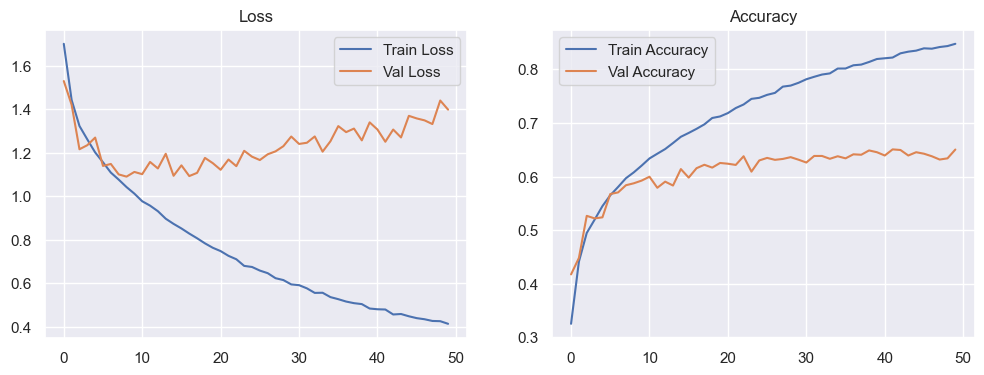

In [25]:
history_6 = {}


# Open the txt file and read the saved history
with open('Histories/training_history_6.txt', 'r') as f:
   
    for line in f:
        key, value_str = line.strip().split(': ')
        value_list = [float(val) for val in value_str[1:-1].split(',')]
        history_6[key] = value_list


histories.append(history_6)
Plots.plot_history_from_file(history_6)

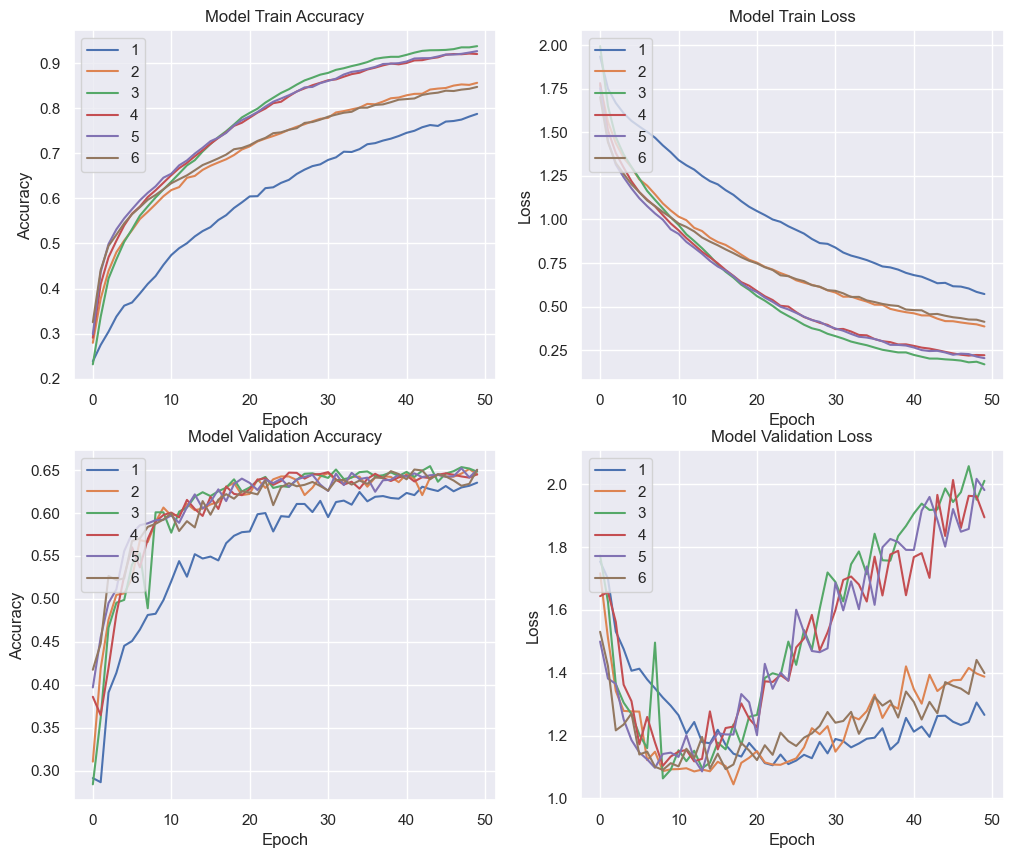

In [8]:
labels = ["1", "2", "3", "4", "5", "6"]

Plots.plot_histories(histories, labels)


Print metrics where val_accuracy is the highest for every model

In [31]:
for idx, h in enumerate(histories): 

    max_val_acc =  np.max(h['val_accuracy'])
    max_index = h['val_accuracy'].index(max_val_acc)
    print(f"Model {idx+1}:")
    for k, v in h.items(): 
        print(f"{k}: {v[max_index]}")
    print()

Model 1:
accuracy: 0.7876972556114197
loss: 0.5725647807121277
val_accuracy: 0.6352744698524475
val_loss: 1.2656803131103516

Model 2:
accuracy: 0.8520672917366028
loss: 0.3987775146961212
val_accuracy: 0.6511563658714294
val_loss: 1.397257924079895

Model 3:
accuracy: 0.9289073348045349
loss: 0.2024974524974823
val_accuracy: 0.654499888420105
val_loss: 1.9192707538604736

Model 4:
accuracy: 0.8623428344726562
loss: 0.37109309434890747
val_accuracy: 0.647534191608429
val_loss: 1.599122405052185

Model 5:
accuracy: 0.9210003614425659
loss: 0.2284594178199768
val_accuracy: 0.6519922614097595
val_loss: 1.857330560684204

Model 6:
accuracy: 0.8219373822212219
loss: 0.4792126417160034
val_accuracy: 0.6505990624427795
val_loss: 1.250931739807129



# Test dataset on the best models
I selected the sixth model as it is between the ones with lower validation loss but it has higher validation accuracy than model 1. 
I selected the third model as well because it obtains the best metrics during training even if it shows the higher validation loss. 

In [ ]:
def test(best_model, test_dataset):
    # Extract the true labels from the test dataset
    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

    # Predict the labels for the test dataset
    test_predictions = best_model.predict(test_dataset)
    test_pred_labels = np.argmax(test_predictions, axis=-1)


    # Print classification report
    print('\nClassification Report:')
    print(classification_report(test_labels, test_pred_labels))




# Define image size and batch size
IMG_SIZE = (48, 48)
BATCH_SIZE = 128

# Load the test dataset
test_dataset = image_dataset_from_directory(
    'data/test',
    shuffle=False, 
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale'
)

# Load the best trained model and test
best_model = Create_models.create_model_6(num_classes=7)

# Load weights for the model
best_model.load_weights('weights/6.weights.h5')
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plot_model(best_model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
test(best_model, test_dataset)

# Reapeat on another model 
best_model_2 = Create_models.create_model_3(num_classes=7)
best_model_2.load_weights('weights/3.weights.h5')
test(best_model_2, test_dataset)


   

Found 3589 files belonging to 7 classes.


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 10, 10, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 4, 4, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,671 (3.10 MB)

 Trainable params: 813,223 (3.10 MB)

 Non-trainable params: 448 (1.75 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.
 1/29 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step

2024-05-29 22:40:21.856400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       491
           1       0.70      0.64      0.67        55
           2       0.59      0.44      0.51       528
           3       0.87      0.86      0.87       879
           4       0.48      0.60      0.53       594
           5       0.78      0.77      0.78       416
           6       0.59      0.66      0.62       626

    accuracy                           0.66      3589
   macro avg       0.66      0.64      0.65      3589
weighted avg       0.67      0.66      0.66      3589



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,868,743 (22.39 MB)

 Trainable params: 5,867,847 (22.38 MB)

 Non-trainable params: 896 (3.50 KB)

 1/29 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step

2024-05-29 22:40:23.065330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       491
           1       0.88      0.65      0.75        55
           2       0.54      0.49      0.51       528
           3       0.88      0.85      0.86       879
           4       0.52      0.55      0.53       594
           5       0.82      0.80      0.81       416
           6       0.64      0.64      0.64       626

    accuracy                           0.67      3589
   macro avg       0.69      0.66      0.67      3589
weighted avg       0.68      0.67      0.67      3589



# Test on pretrained model

EfficientNetB0 with Imagenet weights has been used for a comparison and Dense layers has been added in order to perform the desired classification task. It has been fine_tuned for 10 epochs on the FER dataset but until this point does not show an improved performance compared to the other custom models. 

### Preprocessing

In [ ]:
# Get train and val sets in the shape required from pretrained model 

IMG_SIZE = (224, 224)
BATCH_SIZE = 128

# Load the training dataset
train_dataset = image_dataset_from_directory(
    'data/train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale'
)

# Load the validation dataset
val_dataset = image_dataset_from_directory(
    'data/val',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale'
)


### Fine-tuning

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pretrained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pretrained model
base_model.trainable = False

# Custom input layer and classification layer 
inputs = Input(shape=(224, 224, 1))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)


model_pretrained = Model(inputs, outputs)

# Compile the model
model_pretrained.compile(optimizer=Adam(),  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

# Print model summary
model_pretrained.summary()

# 10 epochs 
epochs = 10

# Fine-tune the model
history_pretrained = model_pretrained.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_pretrained.evaluate(val_dataset)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.3828 - loss: 1.5866 - val_accuracy: 0.4912 - val_loss: 1.3383
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.5012 - loss: 1.3306 - val_accuracy: 0.5121 - val_loss: 1.2770
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 534s 2s/step - accuracy: 0.5218 - loss: 1.2709 - val_accuracy: 0.5124 - val_loss: 1.2789
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.5356 - loss: 1.2291 - val_accuracy: 0.5319 - val_loss: 1.2340
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.5459 - loss: 1.1973 - val_accuracy: 0.5291 - val_loss: 1.2407
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.5604 - loss: 1.1704 - val_accuracy: 0.5397 - val_loss: 1.2055
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.5719 - loss: 1.1459 - val_accuracy: 0.5536 - val_loss: 1.1893
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.5859 - loss: 1.1162 - val_accu

In [ ]:
# Save history in a txt file 
with open('Histories/training_history_pretrained.txt', 'w') as f:
    for key in history_pretrained.history.keys():
        f.write(f'{key}: {history_pretrained.history[key]}\n')

# Save weights in a txt file
model_pretrained.save_weights('weights/pretrained.weights.h5')


In [25]:
# Open the txt file and read the saved history
history_pretrained = []
with open('Histories/training_history_pretrained.txt', 'r') as f:
   
    for line in f:
        key, value_str = line.strip().split(': ')
        value_list = [float(val) for val in value_str[1:-1].split(',')]
        history_pretrained[key] = value_list


### Test

In [31]:
# extract test set in 224x224 size for the pretrained model 
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


IMG_SIZE = (224, 224)
BATCH_SIZE = 128


# Create model 
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pretrained model
base_model.trainable = False

# custom input layer and classification layer 
inputs = Input(shape=(224, 224, 1))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)

model_pretrained = Model(inputs, outputs)

# Load weights from file
model_pretrained.load_weights('weights/pretrained.weights.h5')


test_dataset = image_dataset_from_directory(
    'data/test',
    shuffle=False,  
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='grayscale'
)

test(model_pretrained, test_dataset)


Found 3589 files belonging to 7 classes.


2024-05-29 23:39:50.601356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.28      0.35       491
           1       0.33      0.02      0.03        55
           2       0.36      0.35      0.36       528
           3       0.68      0.75      0.71       879
           4       0.38      0.46      0.41       594
           5       0.59      0.69      0.64       416
           6       0.47      0.45      0.46       626

    accuracy                           0.51      3589
   macro avg       0.47      0.43      0.42      3589
weighted avg       0.50      0.51      0.50      3589

